## Perceptron algorithm with Gradient descent

In [1]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
def perceptron_with_gradient_descent(X,y,num_epochs=20,lr=0.001,precision=10**-3):
  assert type(X)==np.ndarray and type(y)==np.ndarray , "X and y are not  numpy arrays"
  assert X.shape[0] == y.shape[0] , "X and y should have the same number of samples"
  W=np.zeros((1,2))
  delta_w=np.zeros((1,2))
  
  for t in range(num_epochs):
    
    for x_sample,y_sample in zip(X,y):
      o=np.inner(x_sample,W)
      delta_w=(lr * (y_sample-o) * x_sample)
      W=W+delta_w

  return W

In [3]:
 mu = [-1,0]
sigma = [[0.25,0], [0,0.25]]
s1 = np.random.multivariate_normal(mu,sigma,125)

mu = [1,0]
sigma = [[0.25,0], [0,0.25]]
s2 = np.random.multivariate_normal(mu,sigma,125)
s = np.float32(np.concatenate((s1,s2),axis=0))

y = [0] * 125 
y.extend([1] * 125)

y=np.array(y)

In [4]:
s,y= shuffle(s,y)
x_train, x_test, y_train, y_test = train_test_split(s, y, test_size=0.2, random_state=42)

In [5]:
w=perceptron_with_gradient_descent(x_train,y_train)

In [6]:
y_pred = np.inner(x_test,w) 
for i,pred in enumerate(y_pred) :
    if pred > 0 :
        y_pred[i] = 1
    else :
        y_pred[i] = -1
accuracy_score(y_test,y_pred)

0.5

## Neural Network implementation using Tensorflow as a backend

In [7]:
!pip install tensorflow==2.7.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.7.0 (from versions: none)
ERROR: No matching distribution found for tensorflow==2.7.0


In [8]:
import tensorflow as tf
import sys

In [9]:
tf.__version__

'2.6.0'

In [10]:
## Activation functions
class Relu :
  def __call__(self,Z):
    return tf.Variable((Z.numpy() > 0) * Z.numpy() )
  def prime(self,V ):
    return tf.Variable((V.numpy() > 0)  * tf.ones(V.shape).numpy())

class Tanh :
  def __call__(self,Z):
    return (tf.exp(Z)-tf.exp(-Z))/(tf.exp(Z)+tf.exp(-Z))
  def prime(self,V ):
    return (1-self(V)*self(V))

class Sigmoid :
  def __call__(self,Z):
    return 1/(1+tf.exp(-Z))
  def prime(self,V ):
    return  self(V)*(1-self(V))
class Softmax:
  def __call__(self,Z):
    exp = tf.exp(Z - tf.reduce_max(Z))
    return exp / tf.reduce_sum(exp)
  def prime(self,V ):
    return self(V)*(1-self(V))

In [11]:
## Loss functions
class MSE :
  def forward(self,y_true,y_pred):
    return tf.reduce_mean((y_true-y_pred)**2)
  def prime(self,y_true,y_pred):
    m=y_true.shape[0]
    return 2*(y_pred-y_true)/m
    
class CCE:
  def forward(self,y_true, y_pred,epsilon=0.0000001):
    return -1 * tf.math.reduce_mean(y_true * tf.math.log(y_pred + epsilon)+(1-y_true) * tf.math.log(1-y_pred + epsilon))
  def prime(self,y_true, y_pred):
    return y_pred - y_true

In [12]:
## Optimizers 

class RMSProp :
  def __init__(self,beta=0.9,epsilon=0.00001,learning_rate=0.001):
    self.beta=beta
    self.learning_rate=learning_rate
    self.epsilon=epsilon
    self.model=None
  def set_model(self,model) :
    self.model=model
    self.S=[{"W":tf.Variable(tf.zeros((1))),"b":tf.Variable(tf.zeros((1)))} for i in range(1,len(model.layers))]
  def __call__(self) :
    
    for l in range(1,len(self.model.layers)) :
      layer=self.model.layers[l]
      ## updating W
      grad_squared=layer.dW**2
      self.S[l-1]['W']=self.beta*self.S[l-1]['W']+ (1-self.beta)*grad_squared
      ratio=layer.dW / (tf.math.sqrt(self.S[l-1]['W'])+self.epsilon)
      layer.W=layer.W-self.learning_rate * ratio
      ## updating b
      grad_squared=layer.db**2
      self.S[l-1]['b']=self.beta*self.S[l-1]['b']+ (1-self.beta)*grad_squared
      ratio=layer.db / (tf.math.sqrt(self.S[l-1]['b'])+self.epsilon)
      layer.b=layer.b-self.learning_rate * ratio

## Optimizers 

class GradientDescent :
  def __init__(self,learning_rate=0.001):
    self.learning_rate=learning_rate
    self.model=None
    
  def set_model(self,model) :
    self.model=model

  def __call__(self) :
    for l in range(1,len(self.model.layers)) :
      layer=self.model.layers[l]
      ## updating W
      layer.W=layer.W-self.learning_rate * layer.dW
      ## updating b
      layer.b=layer.b-self.learning_rate * layer.db

In [13]:
## Layers 
class Input :
  def __init__(self,input_size) :
    self.input_size=input_size
    self.output_size=input_size
    self.A=tf.Variable(tf.random.normal((input_size,1)))
  def set_input(self,X) :
    self.A=X

class Dense :
  def __init__(self,input_size,output_size,activation='relu') :
    self.input_size=input_size
    self.output_size=output_size
    self.initialize_layer_weights(input_size,output_size)
    self.activation_layer_name=activation
    if activation=='relu' :
      self.activation=Relu()
    elif activation=='sigmoid' :
      self.activation=Sigmoid()
    elif activation=='tanh' :
      self.activation=Tanh()
    elif activation=='softmax' :
      self.activation=Softmax()
    else :
      print("invalid activation function , fallback to default : relu ",file=sys.stderr)
      self.activation=Relu()

  def initalize_parameter(self,size, variance=1.0):
      return tf.Variable((tf.random.normal(size) * variance))
  def initialize_layer_weights(self,input_size,output_size):
      """
      Returns:
      parameters -- python dictionary containing your parameters:
                      W -- weight matrix of shape (input_size, output_size)
                      b -- bias vector of shape (output_size, 1)
      """
      

      self.W = self.initalize_parameter((output_size,input_size ))
      self.b = self.initalize_parameter((output_size, 1))

      assert(self.W.shape == (output_size,input_size ))
      assert(self.b.shape == (output_size, 1))
      

      return self.W,self.b
  def forward(self,X):
    self.Z=tf.Variable(tf.matmul(X,tf.transpose(self.W)).numpy()+self.b.numpy().T)
    self.A=self.activation(self.Z)
    self.X=X
    return self.A
  def backward(self,dA):
    self.dZ = dA * self.activation.prime(self.Z)
    self.db=tf.reduce_mean(self.dZ)*tf.ones(self.b.shape) 
    self.dW= tf.matmul(tf.transpose(self.dZ),self.X) 
    dA_prev=tf.matmul(self.dZ,self.W)
    return dA_prev


In [14]:
## Models
class Sequential :
  def __init__(self,layers) :
    self.layers=layers
    self.trained=False
    self.compiled=False
  def add(self,layer):
    self.layers.append(layer)
  def forward(self,X):
    self.layers[0].set_input(X)
    for l in range(1,len(self.layers)) :
      A=self.layers[l].forward(self.layers[l-1].A)
    return A
  def backward(self,dA):
    for l in range(len(self.layers)-1,0,-1):
      layer=self.layers[l]
      dA=layer.backward(dA)
      
  def compile(self,learning_rate=0.0001,optimizer="Gradient_descent",loss="CCE") :
    if self.compiled :
      print("The model was already compiled",file=sys.stderr)
    if optimizer=="RMSProp" :
      self.optimizer=RMSProp(learning_rate=learning_rate)
    elif optimizer=="Gradient_descent" :
      self.optimizer=GradientDescent(learning_rate=learning_rate)
    elif type(optimizer)==GradientDescent :
      self.optimizer=optimizer
    elif type(optimizer)==RMSProp :
      self.optimizer=optimizer
    else :
      print("Invalid optimizer , fallback to default : Gradient Descent",file=sys.stderr)
    
    if loss=="MSE" :
      self.loss=MSE()
    elif loss=="CCE" :
      self.loss=CCE()
    elif type(loss)==MSE :
      self.loss=loss
    elif type(loss)==CCE :
      self.loss=loss
    else :
      print("Invalid loss function , fallback to default : CCE",file=sys.stderr)

    self.optimizer.set_model(self)
    self.compiled=True
    
      

  def fit(self,training_data,testing_data,epochs=20,batch_size=1):
    if self.compiled==False :
      print("You need to compile the model",file=sys.stderr)
      return
    train_acc_per_epoch=[]
    train_loss_per_epoch=[]
    test_acc_per_epoch=[]
    test_loss_per_epoch=[]
    X_train,y_train=training_data
    X_test,y_test=testing_data
    m=X_train.shape[0]
    m_test=X_test.shape[0]
    nb_batches=X_train.shape[0]//batch_size
    nb_test_batches=X_test.shape[0]//batch_size
    X_train=tf.cast(X_train,dtype=tf.float32)
    X_test=tf.cast(X_test,dtype=tf.float32)
    y_train=tf.cast(y_train,dtype=tf.int32)
    y_test=tf.cast(y_test,dtype=tf.int32)
    for e in range(epochs) :
      curr_s=tf.Variable(0)
      curr_loss=tf.Variable(0,dtype=tf.float32)
      for batch in range(nb_batches) :
        X_s=X_train[batch * batch_size : (batch+1) * batch_size]
        y_s=y_train[batch * batch_size : (batch+1) * batch_size]
        y_pred=self.forward(X_s)
        class_idx = [tf.argmax(yp) for yp  in y_pred]

        one_hot_pred=tf.Variable(tf.zeros(y_pred.shape))
        one_hot_true=tf.Variable(tf.zeros(y_pred.shape))

        for i in range(len(class_idx)) :
          v=tf.Variable(one_hot_pred[i])
          v[class_idx[i]].assign(1.0)
          one_hot_pred[i].assign(v)
          v=tf.Variable(one_hot_true[i])
          v[y_s[i]].assign(1.0)
          one_hot_true[i].assign(v)

        curr_s.assign_add(tf.reduce_sum(tf.cast(tf.Variable(class_idx,dtype=tf.int32)==y_s,dtype=tf.int32)) )
        curr_loss.assign_add(self.loss.forward(one_hot_true,one_hot_pred))
        
        loss_backward=self.loss.prime(one_hot_true,one_hot_pred)
        self.backward(loss_backward)
        
        self.optimizer()
      train_acc_per_epoch.append(curr_s / m)
      train_loss_per_epoch.append(curr_loss / m)


      curr_s=tf.Variable(0)
      curr_loss=tf.Variable(0,dtype=tf.float32)
      for batch in range(nb_test_batches) :
        X_s=X_test[batch * batch_size : (batch+1) * batch_size]
        y_s=y_test[batch * batch_size : (batch+1) * batch_size]
        y_pred=self.forward(X_s)
        class_idx = [tf.argmax(yp) for yp  in y_pred]

        one_hot_pred=tf.Variable(tf.zeros(y_pred.shape))
        one_hot_true=tf.Variable(tf.zeros(y_pred.shape))

        for i in range(len(class_idx)) :
          v=tf.Variable(one_hot_pred[i])
          v[class_idx[i]].assign(1.0)
          one_hot_pred[i].assign(v)
          v=tf.Variable(one_hot_true[i])
          v[y_s[i]].assign(1.0)
          one_hot_true[i].assign(v)

        curr_s.assign_add(tf.reduce_sum(tf.cast(tf.Variable(class_idx,dtype=tf.int32)==y_s,dtype=tf.int32)) )
        curr_loss.assign_add(self.loss.forward(one_hot_true,one_hot_pred))
        


      test_acc_per_epoch.append(curr_s / m_test)
      test_loss_per_epoch.append(curr_loss / m_test)
    self.trained=True
    return {
        "train_acc":train_acc_per_epoch , 
        "train_loss" : train_loss_per_epoch,
        "average_train_acc" : tf.reduce_mean(train_acc_per_epoch),
        "average_train_loss" : tf.reduce_mean(train_loss_per_epoch),
        "test_accuracies":test_acc_per_epoch , 
        "test_losses" : test_loss_per_epoch , 
        "average_test_acc" : tf.reduce_mean(test_acc_per_epoch),
        "average_test_loss" : tf.reduce_mean(test_loss_per_epoch)
    }
  
  def predict (self , X ) :
    y_pred=self.forward(X)
    return y_pred, tf.argmax(y_pred)
  
  def evaluate(self,X_test,y_test):

    if self.trained==False :
      print("You need to train the model")
      return
    test_acc_per_epoch=[]
    test_loss_per_epoch=[]
    m=X_test.shape[0]
    curr_s=tf.Variable(0,type=tf.int32)
    curr_loss=tf.Variable(0,type=tf.float32)
    for X_s,y_s in zip(X_test,y_test) :
      
        y_pred=self.forward(X_s)
        class_idx = [tf.argmax(yp) for yp  in y_pred]

        one_hot_pred=tf.Variable(tf.zeros(y_pred.shape))
        one_hot_true=tf.Variable(tf.zeros(y_pred.shape))

        for i in range(len(class_idx)) :
          v=tf.Variable(one_hot_pred[i])
          v[class_idx[i]].assign(1.0)
          one_hot_pred[i].assign(v)
          v=tf.Variable(one_hot_true[i])
          v[y_s[i]].assign(1.0)
          one_hot_true[i].assign(v)

        curr_s.assign_add(tf.reduce_sum(tf.cast(tf.Variable(class_idx,dtype=tf.int32)==y_s,dtype=tf.int32)) )
        curr_loss.assign_add(self.loss.forward(one_hot_true,one_hot_pred))

    test_acc_per_epoch.append(curr_s / m)
    test_loss_per_epoch.append(curr_loss / m)
      
    return {
        "test_accuracies":test_acc_per_epoch , 
        "test_losses" : test_loss_per_epoch , 
        "average_test_acc" : tf.reduce_mean(test_acc_per_epoch),
        "average_test_loss" : tf.reduce_mean(test_loss_per_epoch)
    }
        




##Toy dataset

In [15]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [16]:
 mu = [-1,0]
sigma = [[0.25,0], [0,0.25]]
s1 = np.random.multivariate_normal(mu,sigma,125)

mu = [1,0]
sigma = [[0.25,0], [0,0.25]]
s2 = np.random.multivariate_normal(mu,sigma,125)
s = np.float32(np.concatenate((s1,s2),axis=0))

y = [0] * 125 
y.extend([1] * 125)

In [17]:
len(y),len(s)

(250, 250)

In [18]:
def convert_np_list_to_tensors(arrays):
  return [ tf.Variable(a) for a in arrays]

In [19]:
s,y= shuffle(s,y)
x_train, x_test, y_train, y_test = train_test_split(s, y, test_size=0.2, random_state=42)

In [20]:
x_train, x_test, y_train, y_test = convert_np_list_to_tensors([x_train, x_test, y_train, y_test])

## Toy dataset with RMSProp

In [21]:
model=Sequential([
               Input(2),Dense(2, 8, 'relu'), Dense(8, 16, 'relu'),Dense(16, 32, 'relu'), Dense(32, 2, 'softmax')
])
model.compile(optimizer=RMSProp(learning_rate=0.001 , beta=0.8),loss=CCE())

In [22]:
history=model.fit((x_train,y_train),(x_test,y_test),batch_size=4,epochs=50)

In [23]:
def plot_history(history):
  plt.figure(figsize=(10, 8))

  plt.title('Accuracy')
  plt.plot(history["train_acc"])
  plt.plot(history["test_accuracies"])
  plt.show()
  plt.figure(figsize=(10, 8))
  plt.title('Loss')
  plt.plot(history["train_loss"])
  plt.plot(history["test_losses"])
  plt.show()

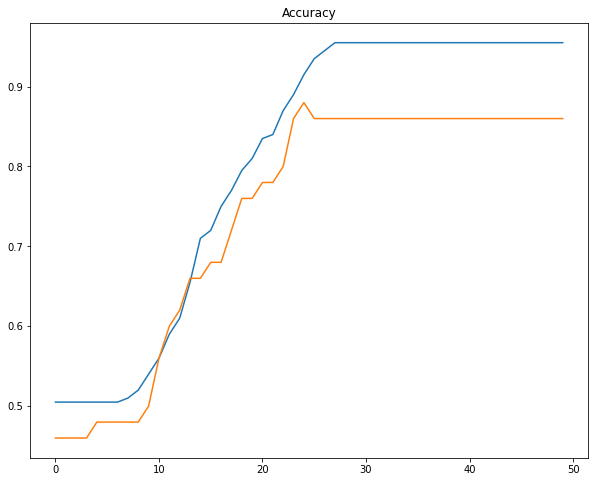

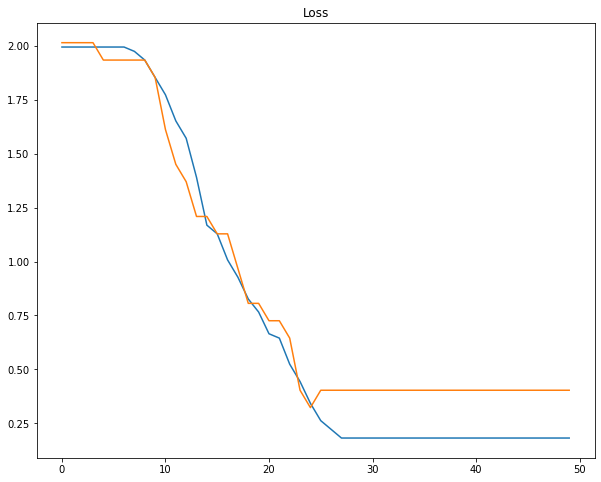

In [24]:
plot_history(history)

## Toy dataset with Gradient Descent

In [25]:
model=Sequential([
               Input(2),Dense(2, 8, 'relu'), Dense(8, 16, 'relu'),Dense(16, 32, 'relu'), Dense(32, 2, 'softmax')
])
model.compile(optimizer=GradientDescent(learning_rate=0.001 ),loss=CCE())

In [26]:
history=model.fit((x_train,y_train),(x_test,y_test),batch_size=2,epochs=50)

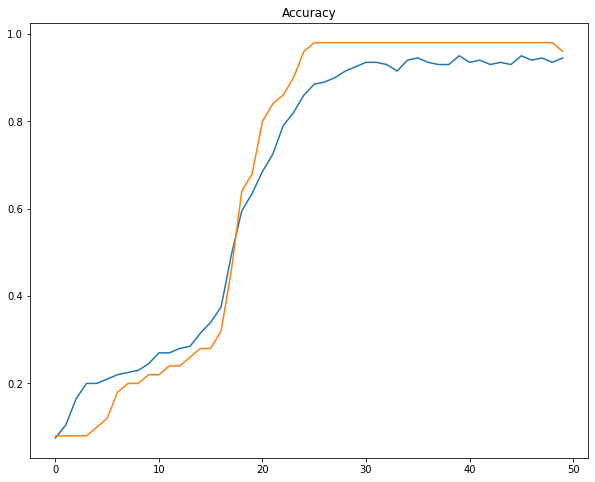

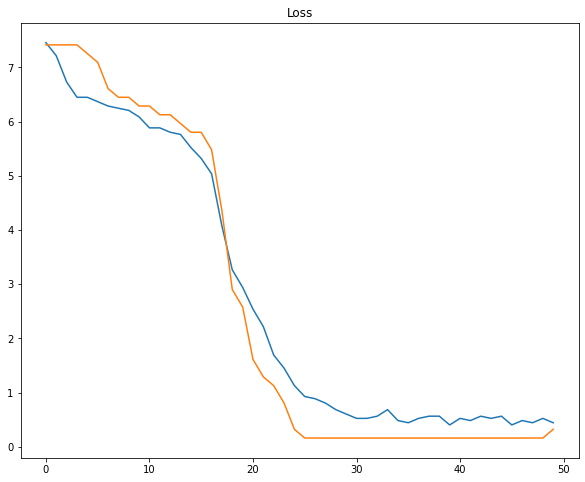

In [27]:
plot_history(history)

## Iris dataset

### First model with optimizer=RMSprop with beta=0.7 , loss=categorical_cross_entropy , lr=0.001 , with 3 hidden layers using relu activation functions , and using softmax for the output layer

In [28]:
from sklearn.datasets import load_iris

In [29]:
iris_dataset = load_iris()

In [30]:
data=iris_dataset['data']
target=iris_dataset['target']

In [31]:
x_train, x_test, y_train, y_test = train_test_split(data,target, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test=convert_np_list_to_tensors([x_train, x_test, y_train, y_test])

### First model with optimizer=RMSprop with beta=0.9 , loss=categorical_cross_entropy , lr=0.001 , with 3 hidden layers using relu activation functions , and using softmax for the output layer

In [66]:
model=Sequential([
               Input(4),Dense(4, 8, 'relu'), Dense(8, 16, 'relu'),Dense(16, 16, 'relu'), Dense(16, 3, 'softmax')
])
model.compile(optimizer=RMSProp(learning_rate=0.001 , beta=0.9),loss=CCE())

In [67]:
history=model.fit((x_train,y_train),(x_test,y_test),epochs=30,batch_size=4)

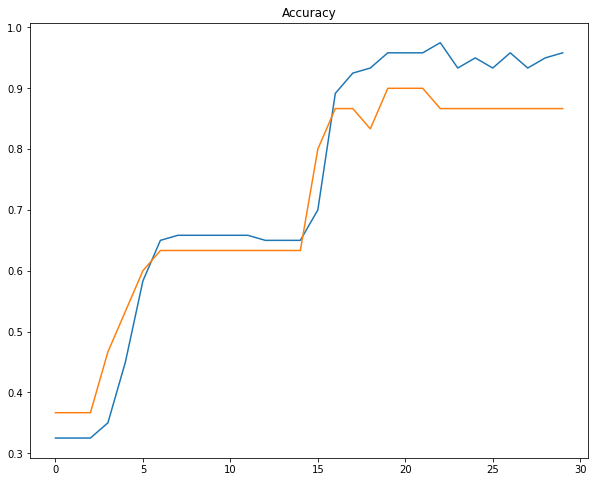

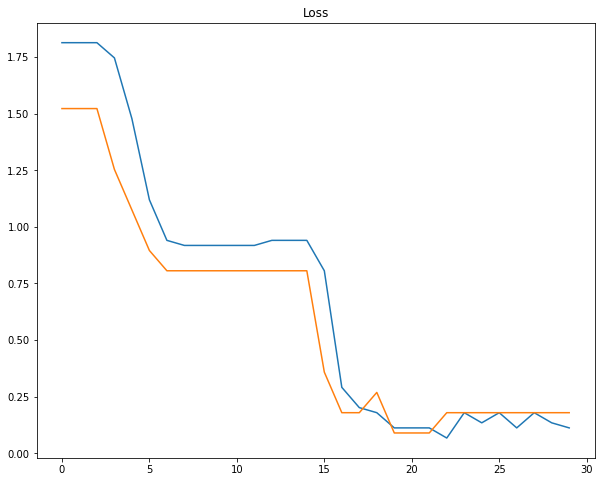

In [68]:
plot_history(history)

### second model with optimizer=RMSprop with beta=0.3 , loss=categorical_cross_entropy , lr=0.001 , with 3 hidden layers using relu activation functions , and using softmax for the output layer

In [59]:
model=Sequential([
               Input(4),Dense(4, 8, 'relu'), Dense(8, 16, 'relu'),Dense(16, 16, 'relu'), Dense(16, 3, 'softmax')
])
model.compile(optimizer=RMSProp(learning_rate=0.001 , beta=0.3),loss=CCE())

In [60]:
history=model.fit((x_train,y_train),(x_test,y_test),epochs=30,batch_size=4)

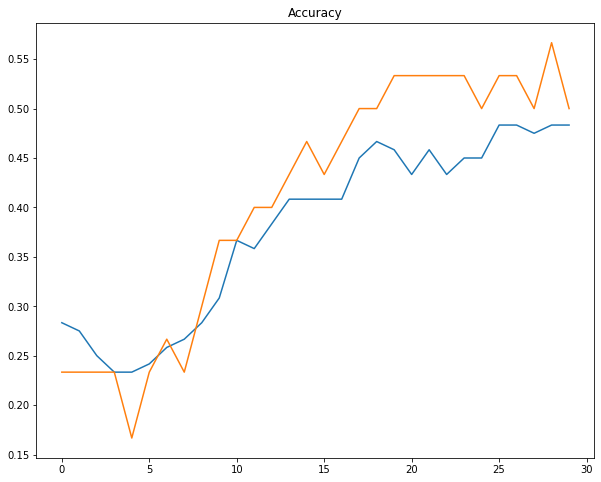

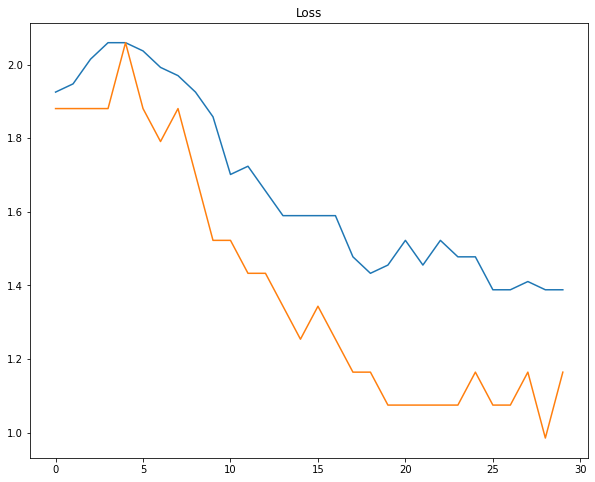

In [61]:
plot_history(history)

#### => For RMSProp , Varying beta can influence how fast a model converges and the accuracy of the model .

## We change the optimizer to gradient descent with lr=0.001

In [35]:
model=Sequential([
               Input(4),Dense(4, 8, 'relu'), Dense(8, 16, 'relu'),Dense(16, 16, 'relu'), Dense(16, 3, 'softmax')
])
model.compile(optimizer=GradientDescent(learning_rate=0.0001),loss=CCE())

In [36]:
history=model.fit((x_train,y_train),(x_test,y_test),epochs=30,batch_size=2)

In [65]:
history

{'train_acc': [<tf.Tensor: shape=(), dtype=float64, numpy=0.325>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.48333333333333334>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.4166666666666667>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.3333333333333333>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.35>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.48333333333333334>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.6>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.36666666666666664>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.5>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.425>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.25>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.25>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.35>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.19166666666666668>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.275>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.3333333333333333>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.33333

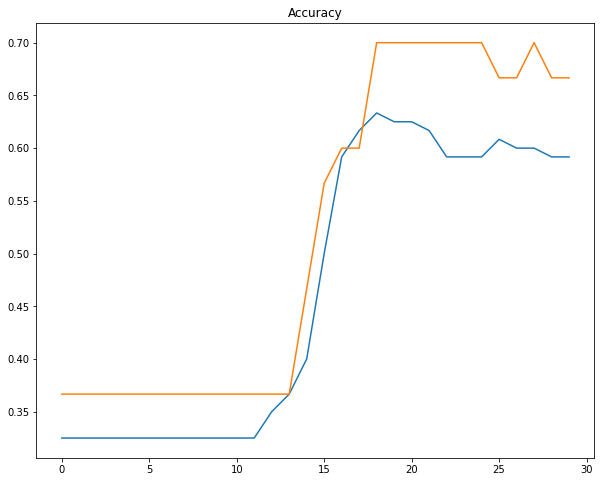

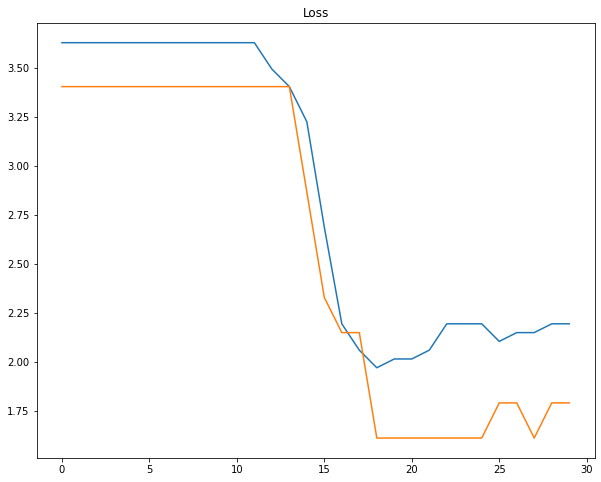

In [37]:
plot_history(history)

#### Gradient Descent is not learning at the first epochs when the initialization is not good and then the loss decreases exponentially , as opposed to RMSProp which takes small steps to reach the minimum

## We vary the learning rate to a high value of 0.01

In [62]:
model=Sequential([
               Input(4),Dense(4, 8, 'relu'), Dense(8, 16, 'relu'),Dense(16, 16, 'relu'), Dense(16, 3, 'softmax')
])
model.compile(optimizer=RMSProp(learning_rate=0.01 , beta=0.9),loss=CCE())

In [63]:
history=model.fit((x_train,y_train),(x_test,y_test),epochs=30,batch_size=2)

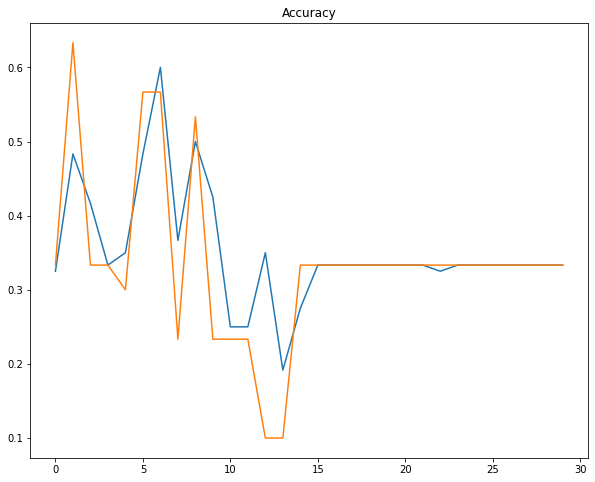

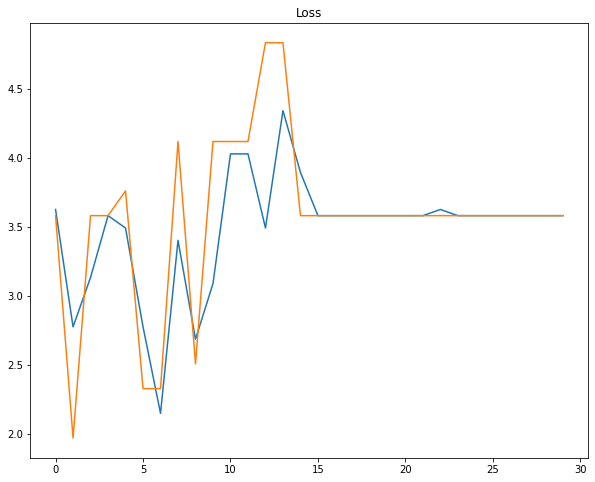

In [64]:
plot_history(history)

#### => For a high learning rate value lr = 0.01 , the model fluctuates and doesn't seem to be able to find the most optimum minimum and is eventually stuck at a local minimum

## We vary the learning rate to a low value of 0.00005

In [41]:
model=Sequential([
               Input(4),Dense(4, 8, 'relu'), Dense(8, 16, 'relu'),Dense(16, 16, 'relu'), Dense(16, 3, 'softmax')
])
model.compile(optimizer=RMSProp(learning_rate=0.00005 , beta=0.9),loss=CCE())

In [42]:
history=model.fit((x_train,y_train),(x_test,y_test),epochs=30,batch_size=2)

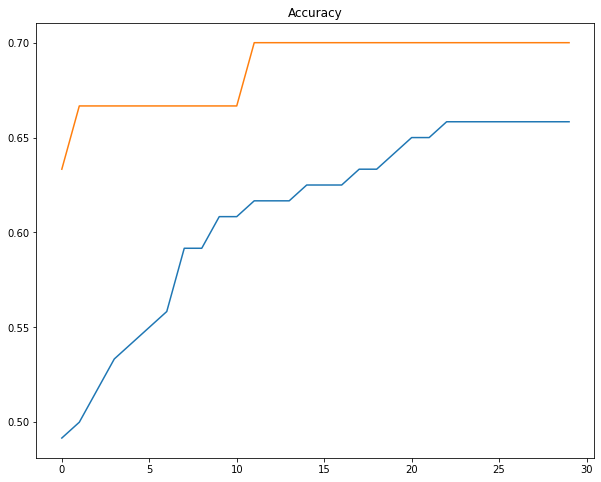

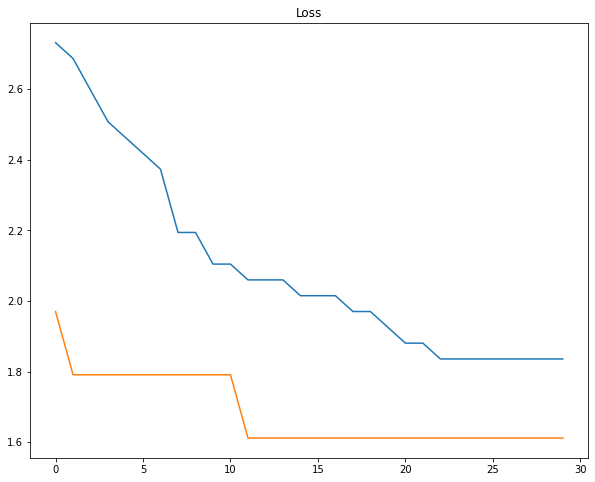

In [43]:
plot_history(history)

#### => For a small value of the learning rate lr = 0.00005 and beta=0.9 , the model takes smaller steps and eventually manages to converge

### First model with optimizer=RMSPROP with  loss=categorical_cross_entropy , lr=0.001 , with 3 hidden layers and  tanh used for activation functions and softmax for the output layer

In [44]:
model=Sequential([
               Input(4),
               Dense(4, 8, 'tanh')
               , Dense(8, 16, 'tanh')
               ,Dense(16,32,'tanh')
               , Dense(32, 3, 'softmax')
])
model.compile(optimizer=RMSProp(learning_rate=0.001 , beta=0.9),loss=CCE())

In [45]:
history=model.fit((x_train,y_train),(x_test,y_test),epochs=30,batch_size=8)

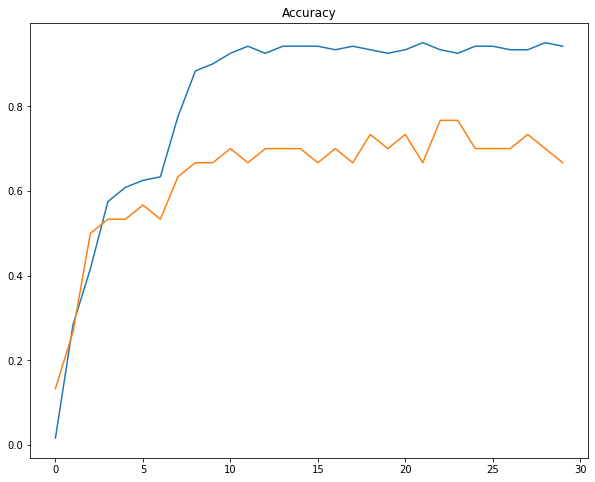

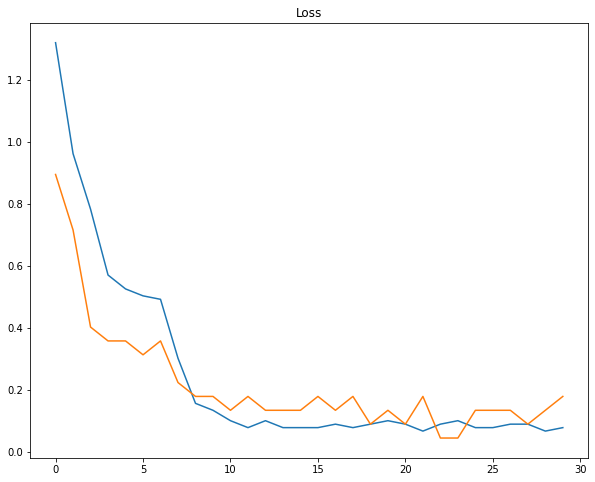

In [46]:
plot_history(history)

#### => By changing the activation functions of the model from relu to tanh , we restrict the outputs of the different layers between -1 and 1 and thus there's a big risk that the gradient would vanish because the derivative of the tanh is always between 0 and 1 which affects W and b .